In [1]:
%load_ext autoreload
%autoreload 2

import sys  
sys.path.insert(0, '/home/bishnu/bishnu/EIC/regressiononly/functions')
sys.path.insert(0, 'training')
from plotting import *
from data_functions import *
import pandas as pd
import numpy as np
import compress_pickle as pickle  


/home/bishnu/miniconda3/envs/tensorflow/lib/python3.8/site-packages/awkward0/__init__.py:8: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if distutils.version.LooseVersion(numpy.__version__) < distutils.version.LooseVersion("1.13.1"):
2023-10-17 17:38:45.004607: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 17:38:45.543196: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



Using variable strings ['E', 'X', 'Y', 'Z'] from binning_utils.py



## Saved Models 

In [6]:
## ECCE (4W + 60 Fe Input 4D, output 1D, Particle = pi+ )
path_to_result='/media/miguel/Elements/ECCE_HCAL/ECCE_ECAL_HCAL_model_theta_10-30/new_models_1Doutput_09-08/\
results_4D_output1D_ECCE_graphnet_FromMyDir/ECCE_20231014-1327_graphnet_4D'

### ZDC (64 Fe , Input 4D, Output 2D, Particle = Neutron )
#path_to_result=f'/media/miguel/Elements/bishnu/zdc_models/results_4D_output2D_ZDC_64Fe_graphnet_FromMyDir_theta_\
#lt4/ECCE_20231014-1641_graphnet_4D"

## PICK the Right models

In [7]:
detector='hcal'   ## insert, hcal, zdc, 
particle ='pi+'  # pi+,  pi0, neutron, gamma
model='graphnet'  ## graphnet, DeepSets
input_features='4D'  ## input features [4D, 2D, 1D]
output_dim='1D'    ## '1D' or '2D'
absorber='4W_60Fe' ## Depends on detector
readout='None' ## None for hcal , insert But for ZDC: h4, h3, unstaggered
include_ecal=True ## False (ZDC it should be False rest True uncless only HCAL data is taken)

entry = conditions.get((detector, particle, model, input_features, output_dim, absorber, readout, include_ecal), default_entry)
path_to_result = entry['result_dir']
path_to_stat = entry['preprocessed_dir']

if entry['result_dir'] == 'No_File':
    print('File not found')    

print(path_to_result)  

/media/miguel/Elements/ECCE_HCAL/ECCE_ECAL_HCAL_model_theta_10-30/new_models_1Doutput_09-08/results_4D_output1D_ECCE_graphnet_FromMyDir/ECCE_20231014-1327_graphnet_4D


## Get predicted and target variable

In [8]:
npz_unpacked = np.load(path_to_result+"/predictions_appended_test.npz")  
predictions_2 = npz_unpacked['outputs_scaled']
targets_2 = npz_unpacked['targets_scaled']

if output_dim=='2D':
    targets_ene = targets_2[:,0]
    targets_theta= targets_2[:,1]

    predictions_ene=predictions_2[:,0]
    predictions_theta=predictions_2[:,1]
    
elif output_dim=='1D':
    targets_ene = targets_2
    predictions_ene=predictions_2


## Inspect the Loss curve

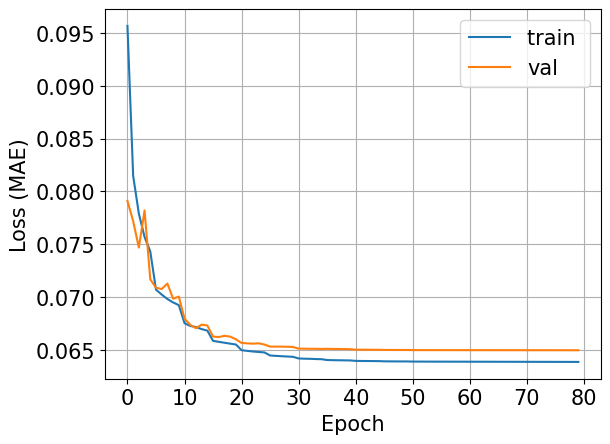

In [9]:
npz_unpacked_loss = np.load(path_to_result + "/losses.npz")

train_loss = npz_unpacked_loss['training']
val_loss = npz_unpacked_loss['validation']
#print(val_loss.shape)
val_mean_loss=np.mean(val_loss, axis=1)
train_mean_loss=np.mean(train_loss, axis=1)
#print(val_mean_loss.shape)

plt.plot(train_mean_loss,label='train ')

plt.plot(val_mean_loss, label='val')
plt.xlabel("Epoch", fontsize=15)
plt.ylabel("Loss (MAE)", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.ylim(0.4,0.52)
plt.legend(fontsize=15)
plt.grid()

## Extract the Fit parameters 
* Energy Resolution is sigma/mean of E_{Pred}/E_{Truth} Distribution as function of Energy
* Theta Resolution is the  sigma of $ \Theta_{pred) $  - $\Theta_{Truth} distribution as function of energy

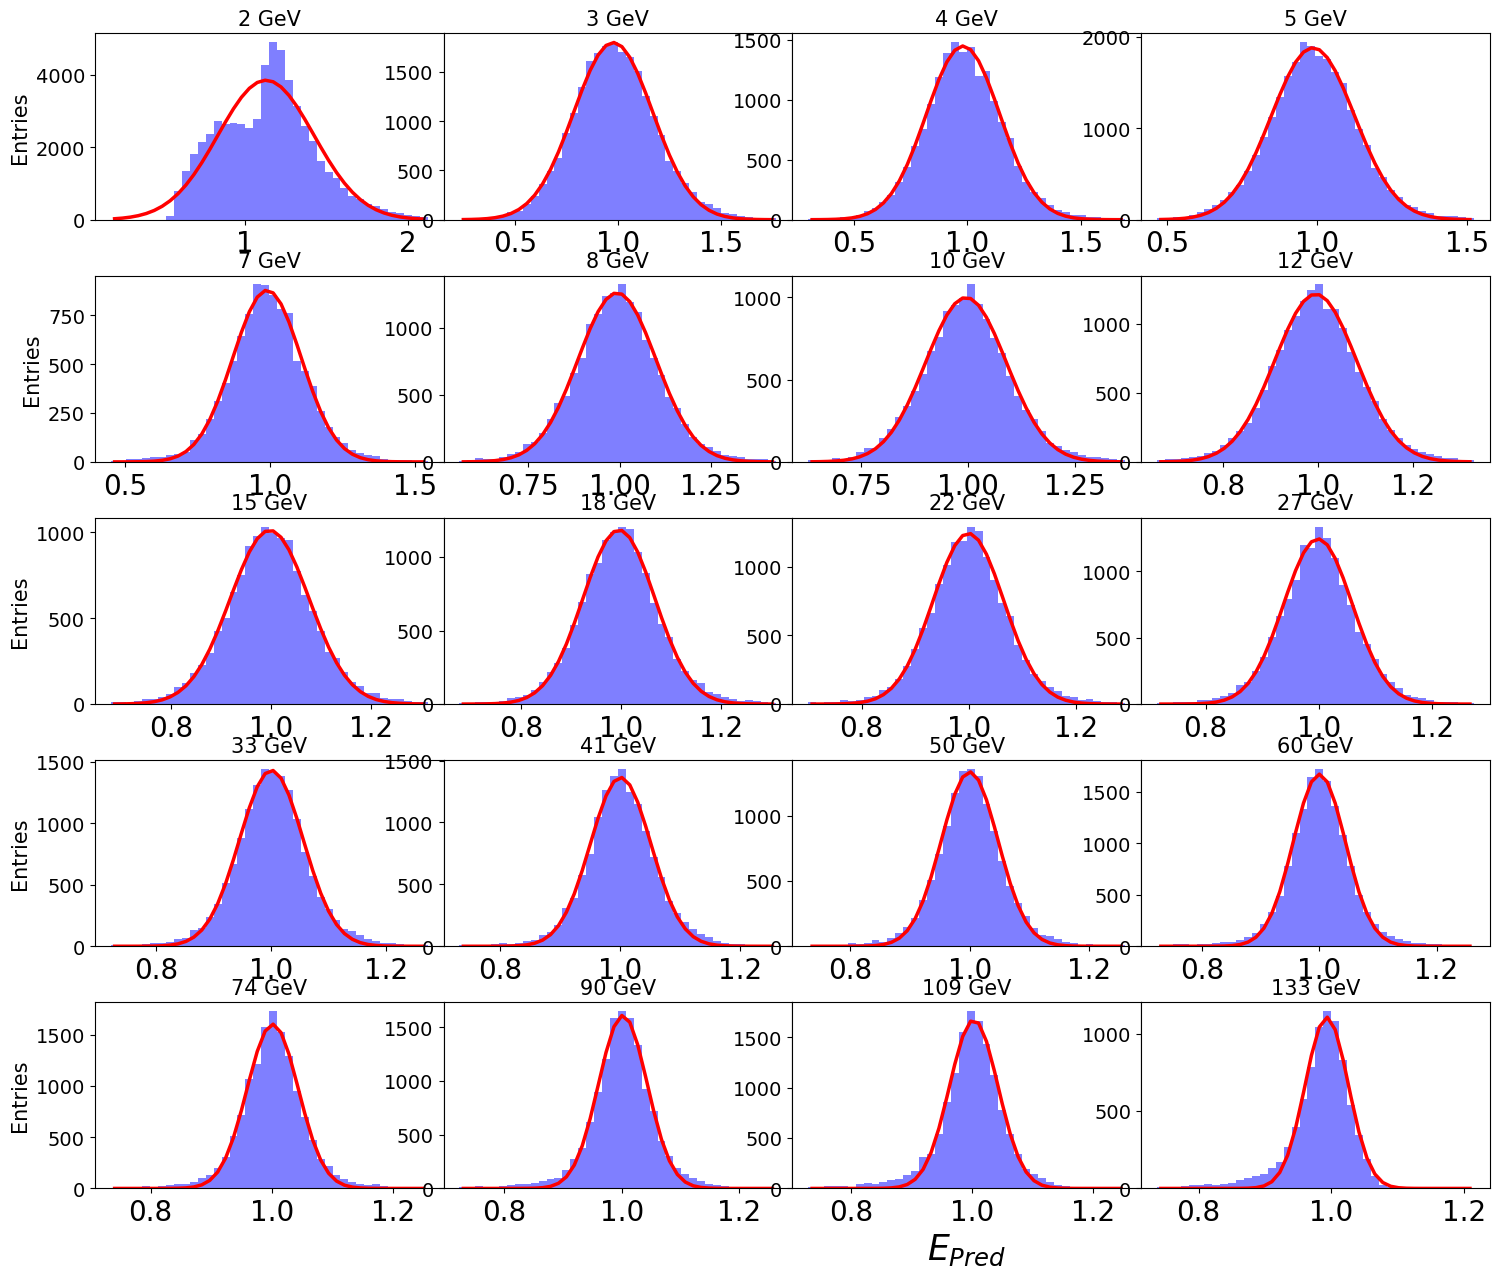

In [10]:
nbins=40
output_path="/home/bishnu/EIC/output_reg_dnn_straw/DeepSets"
data_type='discrete'
particle='pi+'
#detector='hcal'
fit_dist=True
if detector=='zdc':
    binning=[10, 11, 12, 13, 14, 16, 17, 19, 21, 24, 26, 29, 32, 35, 39, 43, 47, 52, 57, 63, 70, 77, 85,\
             93, 103, 114, 125, 138, 152, 168, 185, 204, 225, 248, 274, 302]
else:    
    binning=[ 2, 3, 4, 5, 7, 8, 10, 12, 15, 18, 22, 27, 33, 41, 50, 60, 74,90, 109, 133, 150]


resolution_fit, pred_over_truth_fit, true_fit,slices_fit,slices_pred_truth =get_res_scale_fit_log10_log2\
(targets_ene,predictions_ene, binning, nbins, data_type, particle, 'energy', fit=True, plot_range=0.6)

if output_dim=='2D':
    theta_pred_true_over_true=(predictions_theta - targets_theta)  
    #plt.scatter(targets_theta_plt, prediction_theta_plt, alpha=0.05)
    resolution_fit_th, pred_over_truth_fit_th, true_fit_th,slices_fit_th,slices_pred_truth_th =get_res_scale_fit_log10_log2\
    (targets_ene, theta_pred_true_over_true, binning, nbins, data_type, particle, 'theta-energy', fit=True, plot_range=0.6)

# Print the output and later use to plot

In [12]:
if model=='graphnet':
    approach='gnn_'
elif model=='DeepSets':
    approach='ds_'

particle_detector=f'Input{input_features}_output{output_dim}_{detector}_{absorber}'
name_tag=f'ds_{output_dim}D_output_'
particle='pp'

true_fit=np.round(true_fit, 2)    
print('##------------Energy REGRESSION PARAMETERS---------------------------------------')
print(f'##--Detector = {detector},   Absorber ={absorber },  input = {input_features},  output = {output_dim},\
     Model={model},  ECAL Status={include_ecal}')
print_parameter(true_fit, approach +'energy',particle_detector ) 
print_parameter(resolution_fit, approach +'res_fit', particle_detector ) ## sigma over mean fit 
print_parameter( pred_over_truth_fit, approach +'scale_median', particle_detector )



if output_dim=='2D':
    print('##------------THETA REGRESSION PARAMETERS---------------------------------------')
    print(f'##--Detector = {detector},   Absorber ={absorber },  input = {input_features},  output = {output_dim},\
     Model={model},  ECAL Status={include_ecal}')
    particle_detector=f'Input{input_features}_output{output_dim}_{detector}_{absorber}'
    name_tag=f'ds_{output_dim}D_output_'
    particle='pp'

    true_fit=np.round(true_fit, 2)    
    print_parameter(true_fit_th, approach +'energy',particle_detector ) 
    print_parameter(resolution_fit_th, approach +'theta_res_fit', particle_detector ) ## sigma over mean fit 
   

##------------Energy REGRESSION PARAMETERS---------------------------------------
##--Detector = hcal,   Absorber =4W_60Fe,  input = 4D,  output = 1D,     Model=graphnet,  ECAL Status=True
gnn_energy_Input4D_output1D_hcal_4W_60Fe=np. array([  1.58,   3.  ,   4.  ,   5.45,   7.  ,   8.47,  10.48,  12.95,
        15.97,  19.43,  23.92,  29.41,  36.36,  44.83,  54.32,  66.24,
        81.21,  98.76, 120.12, 140.97])
gnn_res_fit_Input4D_output1D_hcal_4W_60Fe=np. array([0.229198, 0.201183, 0.168489, 0.142142, 0.120761, 0.107714,
       0.095114, 0.086678, 0.079492, 0.072536, 0.065869, 0.060612,
       0.055286, 0.050512, 0.047492, 0.044437, 0.042098, 0.041176,
       0.039804, 0.032995])
gnn_scale_median_Input4D_output1D_hcal_4W_60Fe=np. array([1.130524, 0.976582, 0.981181, 0.986868, 0.989839, 0.993144,
       0.995158, 0.995827, 0.996692, 0.996595, 0.999082, 0.998321,
       1.000458, 1.000394, 0.999959, 1.000317, 1.001059, 1.001725,
       1.002916, 0.993217])


In [14]:
##------------Energy REGRESSION PARAMETERS---------------------------------------
##--Detector = hcal,   Absorber =4W_60Fe,  input = 4D,  output = 1D,     Model=graphnet,  ECAL Status=True
gnn_energy_Input4D_output1D_hcal_4W_60Fe=np. array([  1.58,   3.  ,   4.  ,   5.45,   7.  ,   8.47,  10.48,  12.95,
        15.97,  19.43,  23.92,  29.41,  36.36,  44.83,  54.32,  66.24,
        81.21,  98.76, 120.12, 140.97])
gnn_res_fit_Input4D_output1D_hcal_4W_60Fe=np. array([0.229198, 0.201183, 0.168489, 0.142142, 0.120761, 0.107714,
       0.095114, 0.086678, 0.079492, 0.072536, 0.065869, 0.060612,
       0.055286, 0.050512, 0.047492, 0.044437, 0.042098, 0.041176,
       0.039804, 0.032995])
gnn_scale_median_Input4D_output1D_hcal_4W_60Fe=np. array([1.130524, 0.976582, 0.981181, 0.986868, 0.989839, 0.993144,
       0.995158, 0.995827, 0.996692, 0.996595, 0.999082, 0.998321,
       1.000458, 1.000394, 0.999959, 1.000317, 1.001059, 1.001725,
       1.002916, 0.993217])

Text(0, 0.5, 'Resolution ')

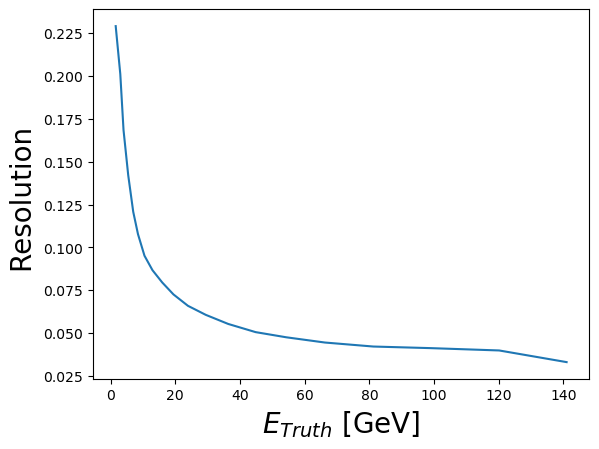

In [16]:
plt.errorbar(gnn_energy_Input4D_output1D_hcal_4W_60Fe, gnn_res_fit_Input4D_output1D_hcal_4W_60Fe)

plt.xlabel('$E_{Truth}$ [GeV]', fontsize=20)
plt.ylabel('Resolution ',  fontsize=20)